In [26]:
# helper functions for fast.ai

# def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
#     x = torch.linspace(min,max)
#     fig,ax = plt.subplots(figsize=figsize)
#     ax.plot(x,f(x))
#     if tx is not None: ax.set_xlabel(tx)
#     if ty is not None: ax.set_ylabel(ty)
#     if title is not None: ax.set_title(title)
        
        
def label_func(fname):
    '''
    function to grab folder name as label name
    '''
    return fname.parent.name

def get_dls(bs, size, augment=True):
    '''
    function to get datablocks
    '''
    if augment:
        batch_tfms=[*aug_transforms(size=size, 
                                    do_flip=True, 
                                    max_rotate = 10.0, 
                                    max_zoom=1.1, 
                                    min_scale=0.75), 
                    Normalize.from_stats(*imagenet_stats)]
    else:
        batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
        
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items=get_image_files, 
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       #get_y=label_func,
                       get_y=parent_label,
                       item_tfms=Resize(460),
                       batch_tfms=batch_tfms)
    return dblock.dataloaders(path, bs=bs)


def new_resnet(pretrained):
    '''
    fix for cnn_learner module using non-standard pre-trained models
    '''
    return default_res50

def accuracy_topk(output, target, topk=(3,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def random_test_image(img_dir, categories):
    """Pick a random test image from specified dir"""
    c = np.random.choice(categories)
    root = img_dir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    print(img_path)
    return img_path

In [35]:
%matplotlib inline

In [27]:
#from helper import *

In [28]:
from fastai.vision.all import *
import torchvision.models as models

In [29]:
!ls ../../data/

DeBoer_Step1  DeBoerStep1.tar.gz  hymenoptera_data


In [30]:
# setting path variables 
Path.BASE_PATH = Path('../../data/DeBoer_Step1')
Path.BASE_PATH.ls()
path = Path.BASE_PATH

In [31]:
data = get_dls(128, 224)
classes = data.vocab

In [32]:
# th architecture to use
arch = 'resnet50'

# (down)load the pre-trained weights
model_weights = '%s_places365.pth.tar' % arch
if not os.access(model_weights, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_weights
    os.system('wget ' + weight_url)
    
places_res50 = torch.load(model_weights,  
                          map_location=lambda storage, 
                          loc: storage)

default_res50 = models.resnet50()
state_dict = places_res50['state_dict'] 
new_state_dict = OrderedDict()

for key in state_dict.keys():
    new_state_dict[key[7:]]= state_dict[key]
    

default_res50.fc = torch.nn.Linear(2048, 365) # Matching with default res50 dense layer
default_res50.load_state_dict(new_state_dict)

<All keys matched successfully>

In [33]:
learn = cnn_learner(get_dls(48, 224, augment=True), 
                    new_resnet,
                    #models.resnet34,
                    metrics=[top_k_accuracy, 
                             accuracy,
                             error_rate])

In [34]:
learn.lr_find()

SuggestedLRs(valley=0.0003981071640737355)

In [36]:
learn.fit_one_cycle(3, 3e-4, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    
                                                   fname='deboer_baseline'), 
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,error_rate,time
0,3.451844,2.458093,0.711538,0.434271,0.565729,02:38
1,2.693963,2.119688,0.771814,0.489093,0.510907,02:38
2,2.390463,2.048094,0.783869,0.502870,0.497130,02:38


Better model found at epoch 0 with valid_loss value: 2.4580934047698975.
Better model found at epoch 1 with valid_loss value: 2.119688034057617.
Better model found at epoch 2 with valid_loss value: 2.048093795776367.


SuggestedLRs(valley=3.630780702224001e-05)

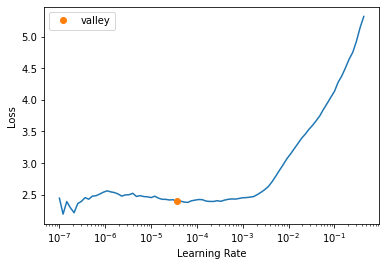

In [37]:
learn.unfreeze()
learn.lr_find()

In [38]:
learn.fit_one_cycle(6,lr_max=slice(1e-5,5e-5))

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,error_rate,time
0,2.329588,2.001641,0.790184,0.513203,0.486797,02:46
1,2.296662,1.914843,0.801665,0.530712,0.469288,02:45
2,2.125989,1.882268,0.809988,0.536165,0.463835,02:46
3,2.009099,1.856725,0.811998,0.539036,0.460964,02:46
4,1.940015,1.834143,0.820034,0.546211,0.453789,02:45
5,1.929263,1.855405,0.817451,0.545924,0.454076,02:45


In [39]:
data = get_dls(128, 224)
classes = data.vocab

In [73]:
label_func(random_path)

'historisch_toneelstuk'

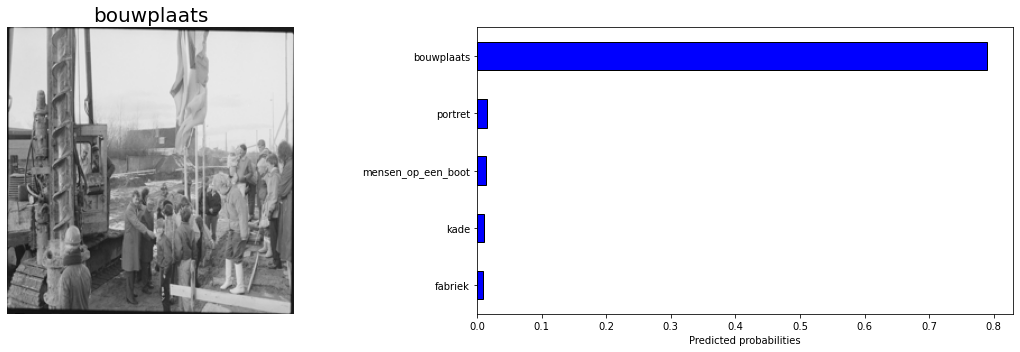

In [82]:
valid_paths = data.valid_ds.items
random_path = random.choice(valid_paths)
label, y, output = learn.predict(random_path)
img = Image.open(random_path)
img = img.resize((256, 256))
probs, preds = output.topk(5)
top_classes = [classes[i] for i in preds]
top5 = list(probs)
result = pd.DataFrame({'p': probs}, index=top_classes)


plt.figure(figsize=(16,5))
ax = plt.subplot(1, 2, 1)
ax.set_title(label_func(random_path), size=20)
ax = plt.imshow(img, cmap='gray')

plt.axis('off')
ax = plt.subplot(1, 2, 2)
result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
plt.xlabel('Predicted probabilities')
plt.tight_layout()
plt.savefig('dining_room.png', dpi=300, bbox_inches='tight')

In [43]:
interp = ClassificationInterpretation.from_learner(learn)

In [53]:
interp.most_confused(min_val=5)

[('uitreiking_huldiging', 'groepsportret', 15),
 ('boten', 'haven', 13),
 ('portret', 'uitreiking_huldiging', 13),
 ('dieren_overig', 'portret', 10),
 ('groepsportret', 'portret', 10),
 ('groepsportret', 'uitreiking_huldiging', 10),
 ('portret', 'kantoor', 10),
 ('woonwijk', 'gebouw', 10),
 ('ontvangst_afscheid', 'uitreiking_huldiging', 9),
 ('bouwplaats', 'gebouw', 8),
 ('straat', 'gebouw', 8),
 ('uitreiking_huldiging', 'portret', 8),
 ('bouwplaats', 'woonwijk', 7),
 ('fabriek', 'bouwplaats', 7),
 ('gebouw', 'bouwplaats', 7),
 ('hockey', 'voetbal', 7),
 ('brug', 'bouwplaats', 6),
 ('portret', 'kunstwerk', 6),
 ('portret', 'tentoonstelling', 6),
 ('speech', 'muziek_optreden', 6),
 ('straat', 'bouwplaats', 6),
 ('bus_truck', 'portret', 5),
 ('dansende_mensen', 'muziek_optreden', 5),
 ('fietsende_mensen', 'straat', 5),
 ('haven', 'boten', 5),
 ('kantoor', 'portret', 5),
 ('markt', 'mensenmassa', 5),
 ('markt', 'winkel_binnen', 5),
 ('mensenmassa', 'optocht', 5),
 ('muziek_optreden', 'mar

In [54]:
interp.print_classification_report()

                        precision    recall  f1-score   support

                 akker       0.69      0.65      0.67        17
           amfitheater       1.00      0.33      0.50         6
                  aula       0.21      0.25      0.23        16
                  auto       0.47      0.64      0.54        11
          auto_ongeluk       0.71      0.23      0.34        22
              bakkerij       0.00      0.00      0.00         9
     basketbal_korfbal       0.73      0.62      0.67        13
         begraafplaats       0.00      0.00      0.00         3
            begrafenis       0.00      0.00      0.00         7
bibliotheek_boekwinkel       0.78      0.47      0.58        15
               biljart       0.00      0.00      0.00         1
        binnen_zwembad       0.70      0.54      0.61        13
               bloemen       0.43      0.19      0.26        16
           bloementuin       0.83      0.50      0.62        10
                boksen       0.00      

/home/mjwever/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjwever/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjwever/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjwever/.local/lib/python3.9/site-packa

In [33]:
learn.save('DeBoer_places')

Path('models/DeBoer_places.pth')

In [45]:
learn = cnn_learner(get_dls(128, 224, augment=True), 
                    new_resnet,
                    #models.resnet34,
                    metrics=[top_k_accuracy, 
                             accuracy,
                             error_rate])

In [46]:
learn.load('DeBoer_places')

In [47]:
label, y, output = learn.predict('../../MelvinWevers#9512/DeBoer_Train/auto_ongeluk/NL-HlmNHA_1478_08130_G.jpg')

In [34]:
learn.export('./models/DeBoer_places.pkl')

In [48]:
probs, preds = output.topk(5)
top_classes = [classes[i] for i in preds]
top5 = list(probs)
result = pd.DataFrame({'p': probs}, index=top_classes)

In [49]:
result

,p
auto_ongeluk,0.851779
auto,0.053180
trein_ongeluk,0.019182
akker,0.019047
kamperen,0.018278


In [40]:
def make_prediction(path, topk=5):
    output_ = {}
    label, y, output = learner.predict(path)
    probs, preds = output.topk(125)
    for index, class_ in enumerate(preds):
        output_[classes[class_]] = round(float(probs[index]),4)
    return output_

In [35]:
learner = load_learner('./models/DeBoer_places.pkl')

In [44]:
make_prediction('../../MelvinWevers#9512/DeBoer_Train/bruiloft/NL-HlmNHA_1478_08555_G.jpg')

{'slagerij': 0.1767,
 'circus': 0.1187,
 'vlag_hijsen': 0.0552,
 'duinen': 0.0462,
 'zeepkistenrace': 0.0284,
 'markt': 0.0275,
 'theater': 0.0264,
 'motorfiets': 0.0256,
 'tafel_tennis': 0.0204,
 'dieren_overig': 0.0202,
 'rugby': 0.0171,
 'handbal': 0.0171,
 'schaken_dammen': 0.0171,
 'zwaan': 0.0166,
 'herdenking': 0.0148,
 'windmolen': 0.014,
 'bos_park': 0.0139,
 'water_ski': 0.0136,
 'hockey': 0.0134,
 'geestelijken': 0.0132,
 'tennis': 0.0117,
 'zaalvoetbal': 0.0115,
 'koe': 0.0102,
 'fabriek': 0.0097,
 'uitreiking_huldiging': 0.0092,
 'trein_ongeluk': 0.0091,
 'sneeuwlandschap': 0.0084,
 'vergaderruimte': 0.0082,
 'wielrennen': 0.008,
 'buiten_zwembad': 0.0077,
 'cafe': 0.0075,
 'dansende_mensen': 0.0074,
 'demonstratie': 0.0073,
 'cricket': 0.0067,
 'begraafplaats': 0.0059,
 'konijn': 0.0053,
 'terras': 0.0053,
 'trein': 0.0051,
 'straat': 0.005,
 'begrafenis': 0.0049,
 'bloementuin': 0.0045,
 'sinterklaas': 0.0045,
 'groepsportret': 0.0044,
 'tram': 0.0044,
 'luchtfoto': 0.00